In [1]:
import json
import cv2
import os
import numpy as np
import sys
import imutils
from imutils.contours import sort_contours
from PIL import Image
import pytesseract as tess
import matplotlib.pyplot as plt
from PIL import Image
from readmrz import MrzDetector, MrzReader
from datetime import datetime
import pycountry

In [2]:
detector = MrzDetector()
reader = MrzReader()

In [3]:
image = detector.read('C:\\Users\\LENOVO\\Desktop\\Project_InternSh\\IDSafeVerify\\static\\uploads\\ID_Moroccan.jpeg')
cropped = detector.crop_area(image)
result = reader.process(cropped)
print(json.dumps(result))

{"surname": "MAATAOUI", "name": "YASMINE", "country": "MAR", "nationality": "MAR", "birth_date": "020701", "expiry_date": "310928", "sex": "F", "document_type": "ID", "document_number": "OPI4O45L", "optional_data": "WB208578", "birth_date_hash": "6", "expiry_date_hash": "1", "document_number_hash": "3", "final_hash": "3"}


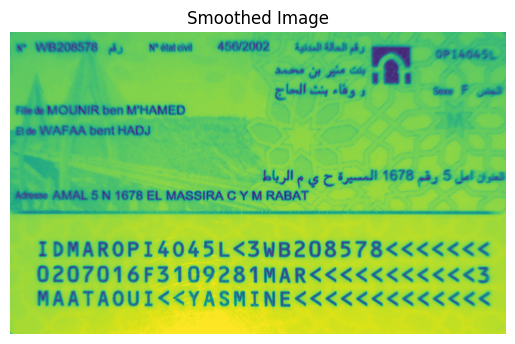

In [4]:
resized = detector.resize(image)
smoothed = detector.smooth(resized)

plt.title('Smoothed Image')
plt.imshow(smoothed)
plt.axis('off');

(np.float64(-0.5), np.float64(984.5), np.float64(599.5), np.float64(-0.5))

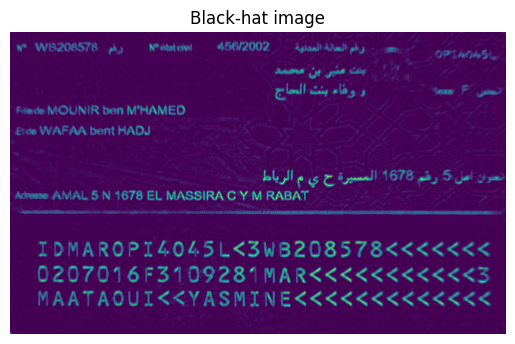

In [5]:
dark = detector.find_dark_regions(smoothed)
plt.title('Black-hat image')
plt.imshow(dark)
plt.axis('off')

In [6]:
def threshold2(dark):
    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    grad = cv2.Sobel(dark, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25, 7))
    sqKernel = cv2.getStructuringElement(
                cv2.MORPH_RECT, 
                (21, 21)
            )
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
            
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    thresh = cv2.erode(thresh, None, iterations=2)
    #plt.imshow(thresh)
    return thresh

In [7]:
thresh = threshold2(dark)

In [8]:
y, y1, x, x1 = detector.find_coordinates(thresh, smoothed)
print(y, y1, x, x1)

401 569 29 988


In [9]:
w = x1 - x
h = y1 - y

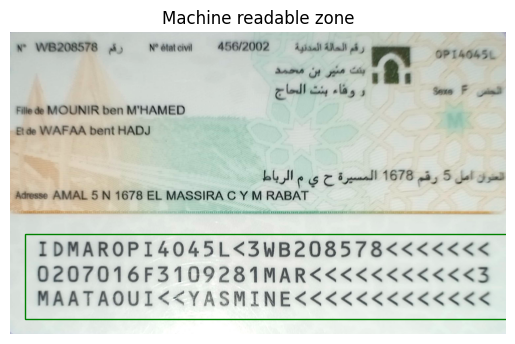

In [10]:
fig, ax = plt.subplots()
ax.imshow(resized)

rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect)

plt.title('Machine readable zone')
plt.axis('off')
plt.show();


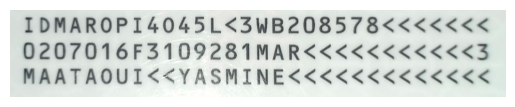

In [11]:
plt.imshow(resized[y:y1, x:x1])
plt.axis('off');

In [12]:
code = reader.read_mrz(resized[y:y1, x:x1])
print(code)

IDMAROPI4O45L<3WB208578<<<<<<<
0207016F3109281MAR<<<<<<<<<<<3
MAATAOUI<<YASMINE<<<<<<<<<<<<<


In [13]:
reader.get_fields(code)

{'surname': 'MAATAOUI',
 'name': 'YASMINE',
 'country': 'MAR',
 'nationality': 'MAR',
 'birth_date': '020701',
 'expiry_date': '310928',
 'sex': 'F',
 'document_type': 'ID',
 'document_number': 'OPI4O45L',
 'optional_data': 'WB208578',
 'birth_date_hash': '6',
 'expiry_date_hash': '1',
 'document_number_hash': '3',
 'final_hash': '3'}

In [14]:
fields = reader.get_fields(code)
print(fields)

{'surname': 'MAATAOUI', 'name': 'YASMINE', 'country': 'MAR', 'nationality': 'MAR', 'birth_date': '020701', 'expiry_date': '310928', 'sex': 'F', 'document_type': 'ID', 'document_number': 'OPI4O45L', 'optional_data': 'WB208578', 'birth_date_hash': '6', 'expiry_date_hash': '1', 'document_number_hash': '3', 'final_hash': '3'}


In [15]:
def clean(string):
    return ''.join(i for i in string if i.isalnum()).upper()

In [16]:
def normalize_date(date_str):
    try:
        date_obj = datetime.strptime(date_str, '%y%m%d').date()
        return date_obj.strftime('%d/%m/%Y')
    except ValueError:
        return 'Invalid Date'

In [17]:
def normalize_country(country_code):
    try:
        country = pycountry.countries.get(alpha_3=country_code)
        return country.name if country else 'Unknown'
    except Exception:
        return 'Unknown'

In [18]:
def normalize_nationality(nationality_code):
    try:
        country = pycountry.countries.get(alpha_3=nationality_code)
        return country.name if country else 'Unknown'
    except Exception:
        return 'Unknown'

In [19]:
def normalize_document_id(doc_id):
    return ''.join(filter(str.isalnum, doc_id)).upper()

In [20]:
normalized_fields = fields.copy()

if 'birth_date' in fields:
    normalized_fields['birth_date'] = normalize_date(fields['birth_date'])
if 'expiry_date' in fields:
    normalized_fields['expiry_date'] = normalize_date(fields['expiry_date'])
if 'country' in fields:
    normalized_fields['country'] = normalize_country(fields['country'])    
if 'nationality' in fields:
    normalized_fields['nationality'] = normalize_nationality(fields['nationality'])
if 'document_number' in fields:
    normalized_fields['document_number'] = normalize_document_id(fields['document_number'])  
if 'surname' in fields:
    normalized_fields['surname'] = normalize_document_id(fields['document_number'])      

print(normalized_fields)

{'surname': 'OPI4O45L', 'name': 'YASMINE', 'country': 'Morocco', 'nationality': 'Morocco', 'birth_date': '01/07/2002', 'expiry_date': '28/09/2031', 'sex': 'F', 'document_type': 'ID', 'document_number': 'OPI4O45L', 'optional_data': 'WB208578', 'birth_date_hash': '6', 'expiry_date_hash': '1', 'document_number_hash': '3', 'final_hash': '3'}


In [9]:
import cv2
import os

def detect_and_display_face(image_path):
  """
  This function attempts to read an image, convert it to grayscale,
  detect faces, and display them. It includes error handling for potential issues.

  Args:
      image_path: The path to the image file.

  Returns:
      None
  """

  try:
    # Read the image
    img = cv2.imread(image_path)

    # Check if image is loaded successfully
    if img is None:
      raise Exception(f"Error: Could not read image from '{image_path}'.")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the face cascade classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangle and handle potential errors during face detection
    if len(faces) == 0:
      print("No faces detected in the image.")
    else:
      for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # Isolate and display the face (potential errors here)
        try:
          face_crop = img[y:y + h, x:x + w]
          cv2.imshow("Face", face_crop)
          cv2.imwrite('face.jpg', face_crop)
        except Exception as e:
          print(f"Error processing face: {e}")

    # Display and save the output image
    cv2.imwrite('detected.jpg', img)
    cv2.imshow('Image', img)
    cv2.waitKey(0)

  except Exception as e:
    print(f"An error occurred: {e}")

image_path = "C:\\Users\\LENOVO\\Desktop\\Project_InternSh\\IDSafeVerify\\static\\uploads\\CIN_Marocaine_Front2.png" 
detect_and_display_face(image_path)

cv2.destroyAllWindows()
